In [16]:
import string
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import ToolMessage
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.runnables import RunnableLambda
import requests
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [ ]:
import os
os.environ["TAVILY_API_KEY"] = "TAVILY_API_KEY"

Developing the weather part of the Model

In [17]:
def get_weather(city_name):
    base_url = "http://api.openweathermap.org/data/2.5/weather"
    params = {
        'q': city_name,
        'appid': "24b0657c347a3437a4e07a8f8030b170",
        'units': 'metric'
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        weather = {
            'city': data['name'],
            'temperature': data['main']['temp'],
            'weather': data['weather'][0]['description'],
            'humidity': data['main']['humidity'],
            'wind_speed': data['wind']['speed']
        }
        return weather
    else:
        return {'error': f"Failed to get weather data: {response.status_code}"}

Developing the tools for math agent

In [18]:
@tool
def multiply(x: float, y: float) -> float:
    """Multiply 'x' times 'y'."""
    return x * y

@tool
def add(x: float, y: float) -> float:
    """Add 'x' and 'y'."""
    return x + y

@tool
def subtract(x: float, y: float) -> float:
    """Subtract 'x' from 'y'."""
    return y - x

@tool
def divide(x: float, y: float) -> float:
    """Divide 'x' by 'y'."""
    return x / y

@tool
def exponentiate(x: float, y: float) -> float:
    """Raise 'x' to the 'y'."""
    return x ** y

tools = [multiply, add, subtract, divide, exponentiate]

In [ ]:
def create_agent(system_prompt: str, tools: list = None, llm: ChatGoogleGenerativeAI = None):
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ])
    if tools and llm:
        return prompt | llm.bind_tools(tools)
    else:
        return prompt | llm

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    google_api_key="GOOGLE_API_KEY"
)

Routing logic with system Prompt

In [20]:
router_system_prompt = """
You are an intelligent router. Given a user's message, decide whether the task is about math, weather, or trending topics.
Only reply with one word: "math", "weather", or "search".
"""
router_agent = create_agent(router_system_prompt, llm=llm)

In [21]:
math_system_prompt = "You are a math expert who can perform basic calculations."
math_agent = create_agent(math_system_prompt, tools=tools, llm=llm)

In [22]:
def route_task(state):
    response = router_agent.invoke({"messages": state["messages"]})
    decision = response.content.lower().strip()
    if "weather" in decision:
        return "weather"
    elif "search" in decision or "trend" in decision:
        return "search"
    else:
        return "math"

Call functions for the three features, Math, Weather Forecast by API and Trending Information via search.

In [23]:
def call_math_model(state, config):
    response = math_agent.invoke({"messages": state["messages"]}, config=config)
    print("Raw response:", response)

    if hasattr(response, "tool_calls") and response.tool_calls:
        tool_call = response.tool_calls[0]
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_map = {t.metadata["name"]: t for t in tools}
        tool_func = tool_map.get(tool_name)
        if tool_func:
            result = tool_func.invoke(tool_args)
            print("Tool result:", result)
            return {"messages": [AIMessage(content=str(result))]}
        else:
            return {"messages": [AIMessage(content="Unknown tool requested.")]}
    else:
        return {"messages": [response]}
def call_weather(state):
    user_input = state["messages"][-1].content.lower()
    city = None
    for kw in ["in", "at"]:
        if kw in user_input:
            city = user_input.split(kw)[-1].strip().strip(string.punctuation)
            break
    if city is None:
        city = user_input.split()[-1].strip(string.punctuation)
    weather_data = get_weather(city)
    return {"messages": [AIMessage(content=str(weather_data))]}

def call_search(state):
    user_input = state["messages"][-1].content
    search = TavilySearchResults(max_results=2)
    result = search.invoke(user_input)
    return {"messages": [AIMessage(content=str(result))]}

In [24]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

workflow = StateGraph(AgentState)

workflow.add_node("router", lambda state: state)
workflow.add_node("math", call_math_model)
workflow.add_node("weather", call_weather)
workflow.add_node("search", call_search)

workflow.set_entry_point("router")

workflow.add_conditional_edges(
    "router",
    route_task,
    {
        "math": "math",
        "weather": "weather",
        "search": "search",
    }
)

workflow.add_edge("math", END)
workflow.add_edge("weather", END)
workflow.add_edge("search", END)

graph = workflow.compile()

Final Graph

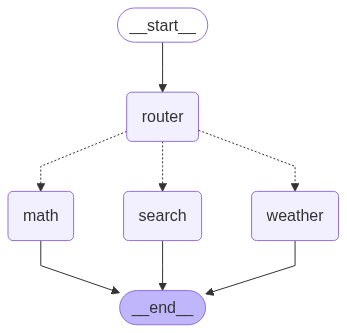

In [25]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

Testing with System Prompt

In [26]:
from langchain_core.messages import HumanMessage

state = {"messages": [HumanMessage(content="What is the weather at Delhi ?")]}
result = graph.invoke(state, config={})
print(result["messages"][-1].content)

{'city': 'Delhi', 'temperature': 29.05, 'weather': 'haze', 'humidity': 65, 'wind_speed': 2.57}


In [29]:
state = {"messages": [HumanMessage(content="What is trending at Delhi ?")]}
result = graph.invoke(state, config={})
print(result["messages"][-1].content)

[{'title': "What's Trending In Delhi? (@delhitrends7865) - Instagram", 'url': 'https://www.instagram.com/delhitrends7865/', 'content': '78 followers · 1 following · 12 posts · @delhitrends7865: “Typical #SouthDelhi guide to frivolous #Delhi #trends, be it #food, #fashion, #travel etc.', 'score': 0.6701125}, {'title': 'Delhi News - The Indian Express', 'url': 'https://indianexpress.com/section/cities/delhi/', 'content': 'Subscribe\nSign In\nTrending\n\nIndia Pakistan News\nMini Crossword\nExpress Shorts\n🎙️ Podcast\n📹 Videos\nHealth & Wellness\n\nAdvertisement\n\nNews\nCities\nDelhi\n\nDELHI NEWS\n‘This is the reality of the BJP’: AAP MP Sanjay Singh hits out at MP minister Kunwar Vijay Shah\n\n\n\nNo arrest yet after Gurgaon shopkeeper shot dead for refusing to deliver samosa\n\n\n\n‘Insult to daughters of the nation’: Amid row over MP minister’s jibe, NCW chief Vijaya Rahatkar bats for Colonel Sofiya Qureshi [...] Explained News\nPolitical Pulse\nLatest Opinion\nMumbai News\nDelhi New

In [31]:
state = {"messages": [HumanMessage(content="What is the weather at Mumbai ?")]}
result = graph.invoke(state, config={})
print(result["messages"][-1].content)

{'city': 'Mumbai', 'temperature': 28.99, 'weather': 'haze', 'humidity': 84, 'wind_speed': 4.12}


In [32]:
state = {"messages": [HumanMessage(content="What is trending at Dubai ?")]}
result = graph.invoke(state, config={})
print(result["messages"][-1].content)

[{'title': 'Monthly trending searches in Dubai, United Arab Emirates | Eventbrite', 'url': 'https://www.eventbrite.com/trending/searches/united-arab-emirates--dubai/', 'content': '24.medical\n\n25.investment\n\n26.investors networking\n\n27.free training dubai\n\n28.dj events\n\n29.difc\n\n30.fintech\n\n31.beach\n\n32.real estate investing\n\n33.art workshops\n\n34.career fair tech\n\n35.legal\n\n36.engineering\n\n37.yoga\n\n38.psychology\n\n39.family office\n\n40.webinars\n\n41.party\n\n42.womens entrepreneurship\n\n43.sip and paint\n\n44.photography\n\n45.pool party\n\n46.wealth management\n\n47.influencer\n\n48.business networking\n\n49.tourism\n\n50.finance and banking\n\n51.competition\n\n52.accounting [...] 53.speakers motivational\n\n54.media\n\n55.content creator\n\n56.students\n\n57.free events\n\n58.trading network\n\n59.pr\n\n60.ux\n\n61.tax\n\n62.crypto\n\n63.transportation and logistics\n\n64.forex\n\n65.youth\n\n66.yacht\n\n67.paid events\n\n68.marina bay\n\n69.yacht part